In [1]:
import numpy as np
from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y


In [3]:
def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])
        
    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [4]:
def fit_MLR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Multiclass Logistic Regression using Gradient Descent 
        Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        Multiclass Logistic Regression: Y ~ vector of discrete RVs with PMF = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
        '''
        k = Y.shape[1] # number of classes 
        if W0 is None:
            W0 = 2*np.random.rand(H.shape[0],k)-1 #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1

In [5]:
def compute_accuracy_metrics(Y_test, P_pred, use_opt_threshold=False, verbose=True):
    
    # y_test = binary label 
    # P_pred = predicted probability for y_test
    # compuate various binary classification accuracy metrics
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, P_pred, pos_label=None)
    mythre = thresholds[np.argmax(tpr - fpr)]
    myauc = metrics.auc(fpr, tpr)
    # print('!!! auc', myauc)
    
    # Compute classification statistics
    threshold = 0.5
    if use_opt_threshold:
        threshold = mythre
    
    Y_pred = P_pred.copy()
    Y_pred[Y_pred < threshold] = 0
    Y_pred[Y_pred >= threshold] = 1

    mcm = confusion_matrix(Y_test, Y_pred)
    
    tn = mcm[0, 0]
    tp = mcm[1, 1]
    fn = mcm[1, 0]
    fp = mcm[0, 1]

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tn / (tn + fp)
    specificity = tp / (tp + fn)
    precision = tp / (tp + fp)
    fall_out = fp / (fp + tn)
    miss_rate = fn / (fn + tp)

    # Save results
    results_dict = {}
    results_dict.update({'Y_test': Y_test})
    results_dict.update({'Y_pred': Y_pred})
    results_dict.update({'AUC': myauc})
    results_dict.update({'Opt_threshold': mythre})
    results_dict.update({'Accuracy': accuracy})
    results_dict.update({'Sensitivity': sensitivity})
    results_dict.update({'Specificity': specificity})
    results_dict.update({'Precision': precision})
    results_dict.update({'Fall_out': fall_out})
    results_dict.update({'Miss_rate': miss_rate})
    results_dict.update({'Confusion_mx': mcm})
    
    
    if verbose:
        for key in [key for key in results_dict.keys()]:
            if key not in ['Y_test', 'Y_pred', 'Confusion_mx']:
                print('% s ===> %.3f' % (key, results_dict.get(key)))
        print('Confusion matrix \n ===>', mcm)
            
    return results_dict

In [6]:

def multiclass_accuracy_metrics(Y_test, P_pred, class_labels=None, use_opt_threshold=False):
    # y_test = multiclass one-hot encoding  labels 
    # Q = predicted probability for y_test
    # compuate various classification accuracy metrics
    results_dict = {}
    y_test = []
    y_pred = []
    for i in np.arange(Y_test.shape[0]):
        for j in np.arange(Y_test.shape[1]):
            if Y_test[i,j] == 1:
                y_test.append(j)
            if P_pred[i,j] == np.max(P_pred[i,:]):
                idx = np.where(P_pred[i,:]==np.max(P_pred[i,:]))
                y_pred.append(np.random.choice(idx[0]))
                
    confusion_mx = metrics.confusion_matrix(y_test, y_pred)
    print('!!! confusion_mx : \n ', confusion_mx)
    results_dict.update({'Confusion_mx':confusion_mx})
    
    return results_dict

In [7]:
idx2word = data_dict.get('idx2word')
categories = data_dict.get('categories')

NameError: name 'data_dict' is not defined

In [9]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.

In [19]:
def sample_binary_MNIST(list_digits=['4','7'], full_MNIST=None):
    # get train and test set from MNIST of given two digits
    # e.g., list_digits = ['0', '1']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.

    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = y[idx]

    X_train = []
    X_test = []
    y_test = [] # list of integers 0 and 1s
    y_train = [] # list of integers 0 and 1s
    
    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        label = 0
        if y01[i] == str(list_digits[1]):
            label = 1

        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(label)
        else:
            X_test.append(X01[i,:])
            y_test.append(label)

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    stuff = [0,1]
   
    Y_train=[]
    for k in [0,1]:
        Y01=[]
        for i in np.arange(y_train.shape[0]):
            label = 0
            if y_train[i] == stuff[k]:
                label = 1
            Y01.append(label)
        Y01 = np.asarray(Y01)
        Y_train.append(Y01)
        
    Y_test=[]
    for k in [0,1]:
        Y01=[]
        for n in np.arange(y_test.shape[0]):
            label = 0
            if y_test[n] == stuff[k]:
                label = 1
            Y01.append(label)
        Y_test.append(Y01)
        
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)
    
    Y_train = Y_train.T
    Y_test = Y_test.T
    return X_train, X_test, Y_train, Y_test


X_train, X_test, Y_train, Y_test = sample_binary_MNIST(list_digits=['4','7'], full_MNIST=[X, y])
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('Y_train.shape', Y_train.shape)
print('Y_test', Y_test.shape)

np.sum(Y_train, axis=0)

X_train.shape (11295, 784)
X_test.shape (2822, 784)
Y_train.shape (11295, 2)
Y_test (2822, 2)


array([5491, 5804])

Text(0.5, 0.98, 'Class conditional PMFs')

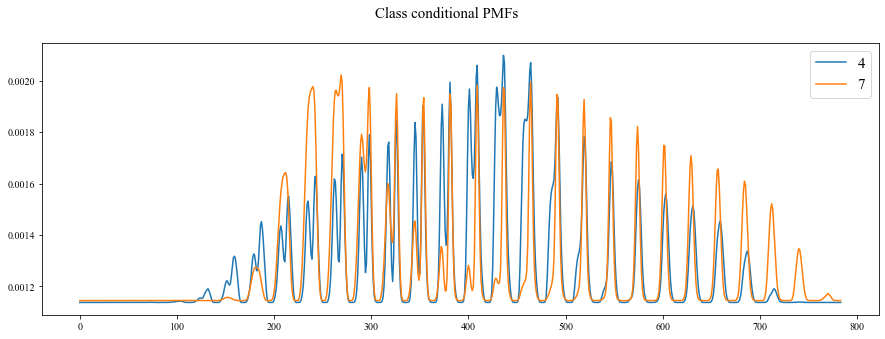

In [20]:
def fit_MNB(Y, H):
    '''
    Fit Multinomial Naive Bayes Calssifier
    Use the Maximum Likelihood prior and class conditional probabilities (in closed forms)
    Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
    prior on class labels = empirical PMF = [ # class i examples / total ]
    class-conditional for class i = [ # word j in class i examples / # words in class i examples]
    Output = prior (k, ), class_conditional_PMF = (k, p)
    '''
    k = Y.shape[1] # number of classes 

    prior = np.sum(Y, axis=0)/np.sum(np.sum(Y, axis=0))

    class_conditional_PMF = []
    for i in np.arange(Y.shape[1]):
        idx = np.where(Y[:,i]==1)
        sub_H = H[:,idx[0]] + 1# add psuedocount
        word_count_per_class = np.sum(sub_H, axis=1)
        class_conditional_PMF.append(word_count_per_class/np.sum(word_count_per_class))

    return prior, np.asarray(class_conditional_PMF)

#test 
H=X_train.T
prior, class_conditional_PMF = fit_MNB(Y=Y_train, H=X_train.T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
ax.plot(np.arange(H.shape[0]), class_conditional_PMF[0], label='4')
ax.plot(np.arange(H.shape[0]), class_conditional_PMF[1], label='7')
ax.legend(fontsize='15')
plt.suptitle("Class conditional PMFs", fontsize='15')

In [21]:
def predict_MNB(X_test, prior, class_conditional_PMF):
    '''
    Compute predicted PMF for the test data given prior and class_conditional_PMF
    Simple use of Bayes' Theorem 
    X_test = (p x n) (words x docs)
    '''
    
    P = class_conditional_PMF / np.min(class_conditional_PMF) # normalize so that log(P) is not too small 
    Q = np.exp(X_test @ np.log(P).T)
    Q = Q * np.repeat(prior[:, np.newaxis], repeats=Q.shape[0], axis=1).T
    sum_of_rows = Q.sum(axis=1)
    
    predictive_PMF = Q / sum_of_rows[:, np.newaxis]
    predictive_PMF = np.asarray(predictive_PMF)
    predictive_PMF = np.concatenate(predictive_PMF, axis=None)
    return predictive_PMF

# test 
predictive_PMF = predict_MNB(X_test, prior, class_conditional_PMF)
print(predictive_PMF.shape)
Y_test_1d=np.concatenate(Y_test, axis=None)
print(Y_test_1d.shape)

(5644,)
(5644,)


AUC ===> 0.975
Opt_threshold ===> 0.507
Accuracy ===> 0.923
Sensitivity ===> 0.923
Specificity ===> 0.923
Precision ===> 0.923
Fall_out ===> 0.077
Miss_rate ===> 0.077
Confusion matrix 
 ===> [[2604  218]
 [ 218 2604]]
AUC ===> 0.992
Opt_threshold ===> 0.512
Accuracy ===> 0.963
Sensitivity ===> 0.963
Specificity ===> 0.963
Precision ===> 0.963
Fall_out ===> 0.037
Miss_rate ===> 0.037
Confusion matrix 
 ===> [[2717  105]
 [ 105 2717]]
AUC ===> 0.996
Opt_threshold ===> 0.544
Accuracy ===> 0.972
Sensitivity ===> 0.972
Specificity ===> 0.972
Precision ===> 0.972
Fall_out ===> 0.028
Miss_rate ===> 0.028
Confusion matrix 
 ===> [[2743   79]
 [  79 2743]]


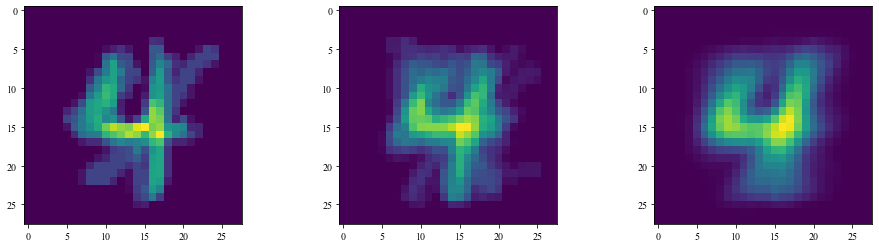

In [29]:
list_train_size = [10, 30, 1000]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[16, 4])
for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(Y_train)), size)
    X_train0 = X_train[idx, :]
    Y_train0 = Y_train[idx, :]
    
    prior, class_conditional_PMF = fit_MNB(Y=Y_train0, H=X_train0.T)
    predictive_PMF = predict_MNB(X_test, prior, class_conditional_PMF)
    Y_test_1d=np.concatenate(Y_test, axis=None)
    result = compute_accuracy_metrics(Y_test = Y_test_1d, P_pred = predictive_PMF)
    
    subtitle = ""
    keys_list = [i for i in result.keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(result.get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    im = ax[i].imshow(class_conditional_PMF[0].reshape(28,28), vmin=np.min(class_conditional_PMF[0]), vmax=np.max(class_conditional_PMF[0]))


AUC ===> 0.915
Opt_threshold ===> 0.508
Accuracy ===> 0.844
Sensitivity ===> 0.844
Specificity ===> 0.844
Precision ===> 0.844
Fall_out ===> 0.156
Miss_rate ===> 0.156
Confusion matrix 
 ===> [[2381  441]
 [ 441 2381]]
AUC ===> 0.961
Opt_threshold ===> 0.511
Accuracy ===> 0.892
Sensitivity ===> 0.892
Specificity ===> 0.892
Precision ===> 0.892
Fall_out ===> 0.108
Miss_rate ===> 0.108
Confusion matrix 
 ===> [[2517  305]
 [ 305 2517]]
AUC ===> 0.990
Opt_threshold ===> 0.512
Accuracy ===> 0.955
Sensitivity ===> 0.955
Specificity ===> 0.955
Precision ===> 0.955
Fall_out ===> 0.045
Miss_rate ===> 0.045
Confusion matrix 
 ===> [[2696  126]
 [ 126 2696]]


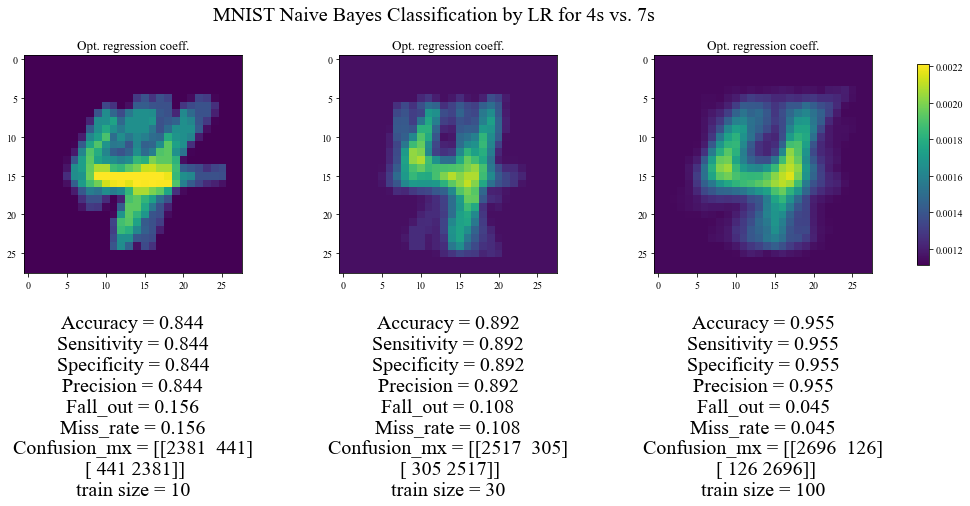

In [33]:
list_train_size = [10, 30, 100]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(Y_train)), size)
    X_train0 = X_train[idx, :]
    Y_train0 = Y_train[idx, :]

    prior, class_conditional_PMF = fit_MNB(Y=Y_train0, H=X_train0.T)
    W_list.append(class_conditional_PMF[0])
    predictive_PMF = predict_MNB(X_test, prior, class_conditional_PMF)
    Y_test_1d=np.concatenate(Y_test, axis=None)

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test = Y_test_1d, P_pred = predictive_PMF)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())
    
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("MNIST Naive Bayes Classification by LR for 4s vs. 7s" , fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [34]:
def sample_binary_MNIST_multi(list_digits=['0','1','2','3','4'], full_MNIST=None):
    # get train and test set from MNIST of given two digits
    # e.g., list_digits = ['0', '1']
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.

    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = y[idx]

    X_train = []
    X_test = []
    y_test = [] # list of integers 0 and 1s
    y_train = [] # list of integers 0 and 1s
    
    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable

        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(y01[i])
        else:
            X_test.append(X01[i,:])
            y_test.append(y01[i])

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    
    stuff = [0,1,2,3,4]
   
    Y_train=[]
    for k in [0,1,2,3,4]:
        Y01=[]
        for i in np.arange(y_train.shape[0]):
            label = 0
            if int(y_train[i]) == stuff[k]:
                label = 1
            Y01.append(label)
        Y01 = np.asarray(Y01)
        Y_train.append(Y01)
        
    Y_test=[]
    for k in [0,1,2,3,4]:
        Y01=[]
        for n in np.arange(y_test.shape[0]):
            label = 0
            if int(y_test[n]) == stuff[k]:
                label = 1
            Y01.append(label)
        Y_test.append(Y01)
        
    Y_train = np.asarray(Y_train)
    Y_test = np.asarray(Y_test)
    
    Y_train = Y_train.T
    Y_test = Y_test.T
    return X_train, X_test, Y_train, Y_test


X_train, X_test, Y_train, Y_test = sample_binary_MNIST_multi(list_digits=['0','1','2','3','4'], full_MNIST=[X, y])
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('Y_train.shape', Y_train.shape)
print('Y_test', Y_test.shape)

np.sum(Y_train, axis=0)

X_train.shape (28500, 784)
X_test.shape (7235, 784)
Y_train.shape (28500, 5)
Y_test (7235, 5)


array([5515, 6332, 5520, 5686, 5447])

Text(0.5, 0.98, 'Class conditional PMFs')

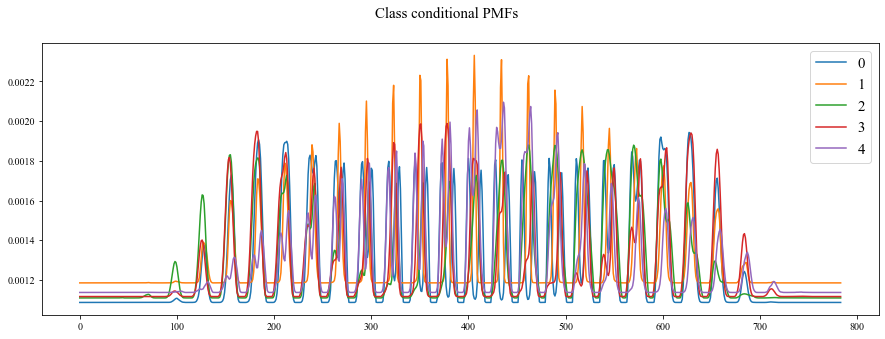

In [35]:
H=X_train.T
prior, class_conditional_PMF = fit_MNB(Y=Y_train, H=X_train.T)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
ax.plot(np.arange(H.shape[0]), class_conditional_PMF[0], label='0')
ax.plot(np.arange(H.shape[0]), class_conditional_PMF[1], label='1')
ax.plot(np.arange(H.shape[0]), class_conditional_PMF[2], label='2')
ax.plot(np.arange(H.shape[0]), class_conditional_PMF[3], label='3')
ax.plot(np.arange(H.shape[0]), class_conditional_PMF[4], label='4')
ax.legend(fontsize='15')
plt.suptitle("Class conditional PMFs", fontsize='15')

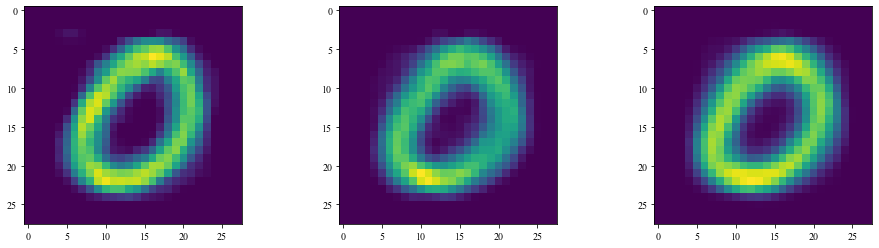

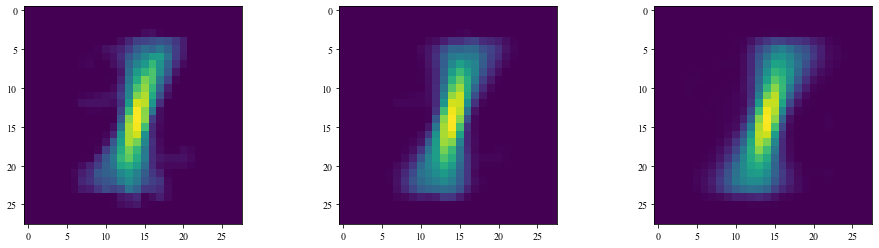

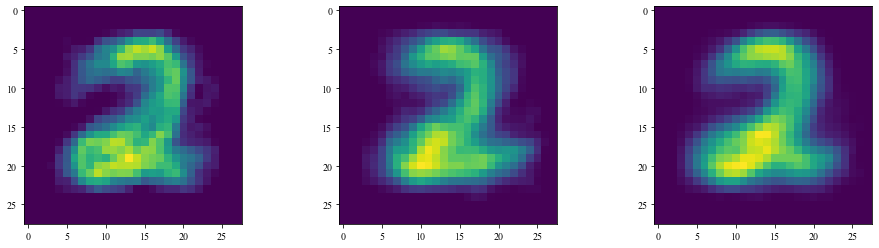

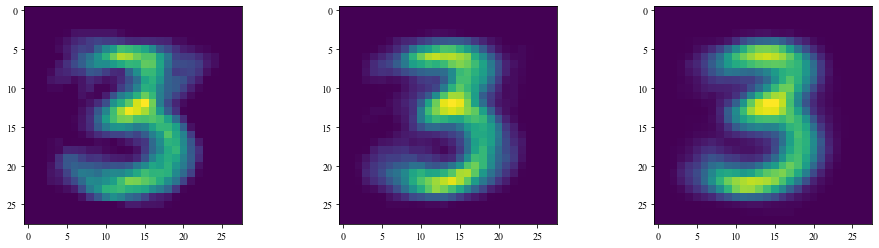

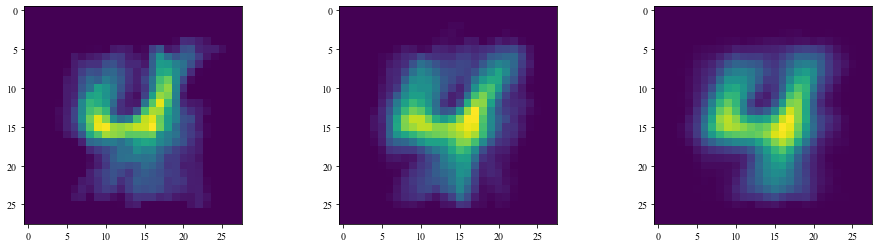

In [37]:
list_train_size = [100, 300, 1000]
for k in [0,1,2,3,4]:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[16, 4])
    for i in np.arange(len(list_train_size)):
        size = list_train_size[i]
        idx = np.random.choice(np.arange(len(Y_train)), size)
        X_train0 = X_train[idx, :]
        Y_train0 = Y_train[idx, :]

        prior, class_conditional_PMF = fit_MNB(Y=Y_train0, H=X_train0.T)
        Q = predict_MNB(X_test,prior,class_conditional_PMF)
        im = ax[i].imshow(class_conditional_PMF[k].reshape(28,28), vmin=np.min(class_conditional_PMF[k]), vmax=np.max(class_conditional_PMF[k]))


AUC ===> 0.985
Opt_threshold ===> 0.128
Accuracy ===> 0.957
Sensitivity ===> 0.975
Specificity ===> 0.886
Precision ===> 0.897
Fall_out ===> 0.025
Miss_rate ===> 0.114
Confusion matrix 
 ===> [[28207   733]
 [  827  6408]]
AUC ===> 0.989
Opt_threshold ===> 0.174
Accuracy ===> 0.962
Sensitivity ===> 0.978
Specificity ===> 0.900
Precision ===> 0.911
Fall_out ===> 0.022
Miss_rate ===> 0.100
Confusion matrix 
 ===> [[28301   639]
 [  721  6514]]
AUC ===> 0.989
Opt_threshold ===> 0.160
Accuracy ===> 0.963
Sensitivity ===> 0.978
Specificity ===> 0.902
Precision ===> 0.911
Fall_out ===> 0.022
Miss_rate ===> 0.098
Confusion matrix 
 ===> [[28303   637]
 [  708  6527]]


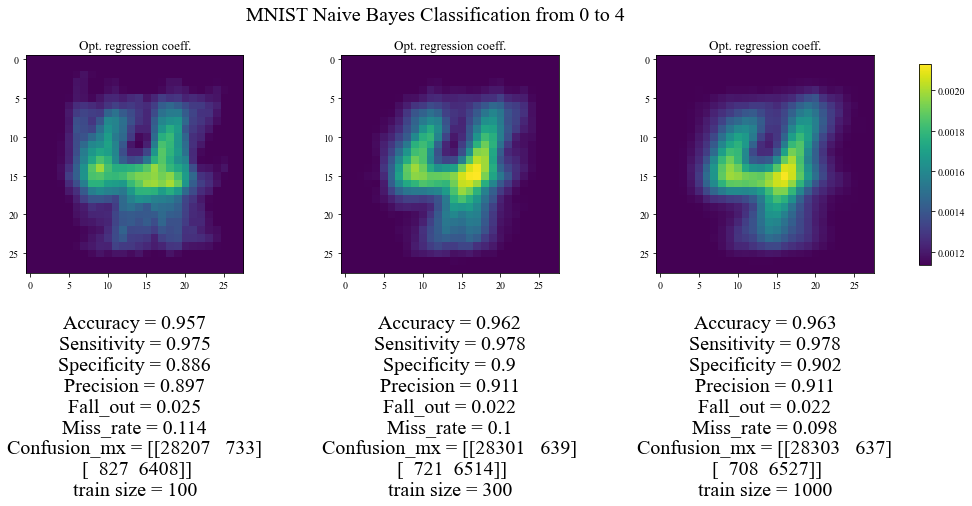

In [39]:
list_train_size = [100, 300, 1000]

# train the regression coefficients for all cases
W_list = []
results_list = []

for i in np.arange(len(list_train_size)):
    size = list_train_size[i]
    idx = np.random.choice(np.arange(len(Y_train)), size)
    X_train0 = X_train[idx, :]
    Y_train0 = Y_train[idx, :]

    prior, class_conditional_PMF = fit_MNB(Y=Y_train0, H=X_train0.T)
    W_list.append(class_conditional_PMF[4])
    predictive_PMF = predict_MNB(X_test, prior, class_conditional_PMF)
    Y_test_1d=np.concatenate(Y_test, axis=None)

    # Compute binary classification accuracies
    results_dict = compute_accuracy_metrics(Y_test = Y_test_1d, P_pred = predictive_PMF)
    results_dict.update({'train size':X_train0.shape[0]})  # add the train data size to the results dictionary
    results_list.append(results_dict.copy())
    
fig, ax = plt.subplots(nrows=1, ncols=len(list_train_size), figsize=[16, 4])

for i in np.arange(len(list_train_size)):
    result_dict = results_list[i]
    W = W_list[i] 
    im = ax[i].imshow(W.copy().reshape(28,28), vmin=np.min(W_list), vmax=np.max(W_list))
    
    subtitle = ""
    keys_list = [i for i in results_list[i].keys()]
    for key in keys_list:
        if key not in ['Y_test', 'Y_pred', 'AUC', 'Opt_threshold']:
            subtitle += "\n" + str(key) + " = " + str(np.round(results_list[i].get(key),3))
            # print('%s = %f' % (key, results_list[i].get(key)))
            
    ax[i].set_title('Opt. regression coeff.', fontsize=13) 
    ax[i].set_xlabel(subtitle, fontsize=20) 

fig.subplots_adjust(right=0.9)
fig.suptitle("MNIST Naive Bayes Classification from 0 to 4" , fontsize=20, y=1.05)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)